# Eine Analyse der Landnutzungsänderung in Indonesien: Überprüfung der Null-Abholzungsverpflichtung mittels Fernerkundung

Google Drive in Colab mounten.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Erforderliche Bibliotheken in Colab installieren.

In [2]:
# Installiere fehlende Bibliotheken in Colab
!pip install rasterio geopandas tqdm matplotlib scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 90.6 MB/s eta 0:00:00


Importieren der notwendigen Bibliotheken wie rasterio, geopandas, pandas, numpy, scikit-learn, matplotlib und tqdm.

In [9]:
import os
import rasterio
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.transform import from_origin
from rasterio.features import geometry_mask
from rasterio.plot import show
from rasterio.features import sieve
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

Definieren der Input- und Output-Verzeichnisse.

In [4]:
input_dir = '/content/drive/My Drive/Colab Notebooks/LCC/input_dir'
output_dir = '/content/drive/My Drive/Colab Notebooks/LCC/output_dir'

# Überprüfen, ob die Verzeichnisse korrekt eingebunden sind
print("Input Directory:", os.listdir(input_dir))
print("Output Directory:", os.listdir(output_dir))

Input Directory: ['MTD_MSIL2A_23.xml', 'T49MHS_20230902T022541_B8A_20m.jp2', 'T49MHS_20230902T022541_B04_10m.jp2', 'T49MHS_20230902T022541_B06_20m.jp2', 'T49MHS_20230902T022541_B02_10m.jp2', 'T49MHS_20230902T022541_B08_10m.jp2', 'T49MHS_20230902T022541_TCI_10m.jp2', 'T49MHS_20230902T022541_B07_20m.jp2', 'T49MHS_20230902T022541_B12_20m.jp2', 'T49MHS_20230902T022541_B03_10m.jp2', 'T49MHS_20230902T022541_B11_20m.jp2', 'T49MHS_20230902T022541_B05_20m.jp2', 'T49MHS_20230902T022541_B01_20m.jp2', 'T49MHS_20191023T022741_B07_20m.jp2', 'T49MHS_20191023T022741_B08_10m.jp2', 'T49MHS_20191023T022741_B11_20m.jp2', 'T49MHS_20191023T022741_B02_10m.jp2', 'T49MHS_20191023T022741_B04_10m.jp2', 'T49MHS_20191023T022741_B01_20m.jp2', 'T49MHS_20191023T022741_B12_20m.jp2', 'T49MHS_20191023T022741_B05_20m.jp2', 'T49MHS_20191023T022741_B06_20m.jp2', 'T49MHS_20191023T022741_B03_10m.jp2', 'T49MHS_20191023T022741_B8A_20m.jp2', 'T49MHS_20191023T022741_TCI_10m.jp2', 'MTD_MSIL2A_19.xml', 'data-indo.qgs', 'data-indo_

## 1. Verarbeitung der Geodaten von 2023
Überblick: Laden der Trainingsdaten (Shapefile) und Rasterdaten als TCI.

   macroclass  class_id MC_Name ID_Name  \
0           1         1   Water   Ocean   
1           1         1   Water   Ocean   
2           1         1   Water   Ocean   
3           1         1   Water   Ocean   
4           1         1   Water   Ocean   

                                            geometry  
0  POLYGON ((905466.258 9611079.519, 905477.066 9...  
1  POLYGON ((820623.751 9608416.131, 811728.238 9...  
2  POLYGON ((822132.498 9615934.114, 819817.486 9...  
3  POLYGON ((804843.567 9603721.646, 821354.448 9...  
4  POLYGON ((885274.706 9611293.951, 884383.024 9...  


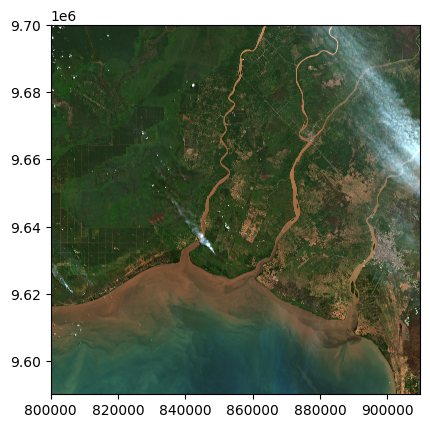

<Axes: >

In [ ]:
# Shapefile laden
shape_loc_23 = f'{input_dir}/SCP-training-data-T49MHS-23.shp'
gdf_23 = gpd.read_file(shape_loc_23)

# Rasterdaten laden
raster_loc_23 = f'{input_dir}/T49MHS_20230902T022541_TCI_10m.jp2'
raster_23 = rasterio.open(raster_loc_23)

# Anzeigen der ersten Zeilen der Shapefile-Daten
print(gdf_23.head())

# Anzeigen der Rasterdaten
show(raster_23)

### 1.1 Preprocessing
Prüfen der Trainingsdaten auf Fehler und Konvertierung der Datentypen falls notwendig.

In [ ]:
# Prüfen und Konvertieren der 'macroclass'-Spalte
print("Datentypen vor der Konvertierung:")
print(gdf_23.dtypes)

# Prüfen, ob alle Werte in der Spalte macroclass vom Typ int64 sind
if gdf_23['macroclass'].dtype != np.int64:
    print("\nDie Spalte 'macroclass' enthält nicht nur int64-Werte!")

    # Identifizieren ungültiger Werte
    invalid_values = gdf_23[~gdf_23['macroclass'].apply(lambda x: isinstance(x, (int, np.integer)))]
    print("\nUngültige Werte in 'macroclass':")
    print(invalid_values)

    # Versuchen, die Werte zu konvertieren
    try:
        gdf_23['macroclass'] = gdf_23['macroclass'].astype('Int64')  # Pandas Integer-Typ mit NaN-Unterstützung
        print("\nKonvertierung erfolgreich. Neuer Datentyp:")
        print(gdf_23.dtypes)
    except ValueError as e:
        print("\nFehler bei der Konvertierung:", e)
        # Entfernen der Zeilen mit ungültigen Werten
        gdf_23 = gdf_23[gdf_23['macroclass'].apply(lambda x: isinstance(x, (int, np.integer)))]

# Überprüfen der Geometrie auf Fehler und Entfernen ungültiger Geometrien
def remove_invalid_geometry(df):
    invalid_geometries = df[~df.is_valid]
    if not invalid_geometries.empty:
        print("\nUngültige Geometrien:")
        print(invalid_geometries)
    valid_df = df[df.is_valid]
    print(f"Anzahl gültiger Geometrien nach Bereinigung: {len(valid_df)}")
    return valid_df

gdf_23 = remove_invalid_geometry(gdf_23)

# Geänderte Datei speichern und Originaldatei ersetzen
gdf_23.to_file(shape_loc_23)
print(f"Das bereinigte Shapefile wurde erfolgreich unter {shape_loc_23} gespeichert.")

Datentypen vor der Konvertierung:
macroclass       int64
class_id         int64
MC_Name         object
ID_Name         object
geometry      geometry
dtype: object
Anzahl gültiger Geometrien nach Bereinigung: 1116
Das bereinigte Shapefile wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/input_dir/SCP-training-data-T49MHS-23.shp gespeichert.


Laden der relevanten Bänder (B01, B02, B03, B04, B05, B06, B07, B08, B08A, B11, B12) und Resampling der 20 m Bänder auf 10 m mithilfe der bilinearen Resampling-Methode.

In [ ]:
# Input-Dateien
raster_dir_23 = input_dir
shape_loc_23 = f'{input_dir}/SCP-training-data-T49MHS-23.shp'

# Relevante Bänder mit der höchsten Auflösung (10m und 20m) laden
band_files_10m_23 = [
    'T49MHS_20230902T022541_B02_10m.jp2', 'T49MHS_20230902T022541_B03_10m.jp2',
    'T49MHS_20230902T022541_B04_10m.jp2', 'T49MHS_20230902T022541_B08_10m.jp2'
]
band_files_20m_23 = [
    'T49MHS_20230902T022541_B01_20m.jp2', 'T49MHS_20230902T022541_B05_20m.jp2',
    'T49MHS_20230902T022541_B06_20m.jp2', 'T49MHS_20230902T022541_B07_20m.jp2',
    'T49MHS_20230902T022541_B8A_20m.jp2', 'T49MHS_20230902T022541_B11_20m.jp2',
    'T49MHS_20230902T022541_B12_20m.jp2'
]

bands_23 = []

# 10m Bänder laden
for band_file in band_files_10m_23:
    with rio.open(f'{raster_dir_23}/{band_file}') as src:
        bands_23.append(src.read(1))

# 20m Bänder laden und auf 10m resamplen
for band_file in band_files_20m_23:
    with rio.open(f'{raster_dir_23}/{band_file}') as src:
        data = src.read(
            out_shape=(src.count, src.height * 2, src.width * 2),
            resampling=Resampling.bilinear
        )
        bands_23.append(data[0])

bands_23 = np.array(bands_23)

# Shapefile laden
gdf_23 = gpd.read_file(shape_loc_23)

# Sicherstellen, dass das Shapefile das gleiche CRS hat wie das Raster
with rio.open(f'{raster_dir_23}/{band_files_10m_23[0]}') as src:
    crs_23 = src.crs
    transform_23 = src.transform

if gdf_23.crs != crs_23:
    gdf_23 = gdf_23.to_crs(crs_23)

# Dimensionen des Rasters bestimmen
height_23, width_23 = bands_23.shape[1], bands_23.shape[2]

Bestimmen und Visualisieren der spektralen Signaturen der Trainingsflächen (= MW Pixelwerte pro Klasse).

BOA Quantification Value: 10000.0
Band 0: BOA Add Offset: -1000.0
Band 1: BOA Add Offset: -1000.0
Band 2: BOA Add Offset: -1000.0
Band 3: BOA Add Offset: -1000.0
Band 4: BOA Add Offset: -1000.0
Band 5: BOA Add Offset: -1000.0
Band 6: BOA Add Offset: -1000.0
Band 7: BOA Add Offset: -1000.0
Band 8: BOA Add Offset: -1000.0
Band 9: BOA Add Offset: -1000.0
Band 10: BOA Add Offset: -1000.0
Band 11: BOA Add Offset: -1000.0
Band 12: BOA Add Offset: -1000.0


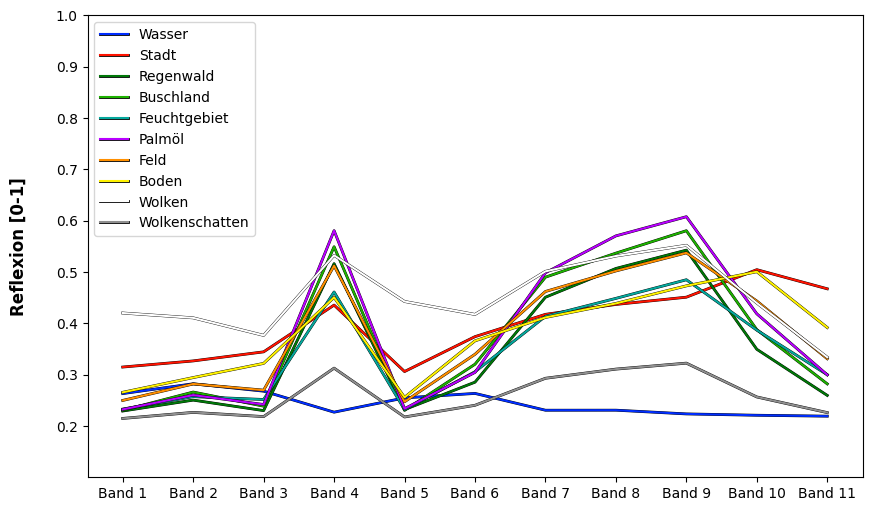

In [ ]:
# Pfad zur Metadatendatei
metadata_23 = f'{input_dir}/MTD_MSIL2A_23.xml'

# Metadaten auslesen
tree = ET.parse(metadata_23)
root = tree.getroot()

# BOA Quantification Value extrahieren
boa_quantification_value = float(root.find(".//QUANTIFICATION_VALUES_LIST/BOA_QUANTIFICATION_VALUE").text)
print(f'BOA Quantification Value: {boa_quantification_value}')

# BOA Add Offset Werte extrahieren und ausgeben
boa_add_offsets = root.findall(".//BOA_ADD_OFFSET_VALUES_LIST/BOA_ADD_OFFSET")
reflectance_add_band = []
for offset in boa_add_offsets:
    band_id = int(offset.attrib['band_id'])
    add_offset = float(offset.text)
    reflectance_add_band.append(add_offset)
    print(f'Band {band_id}: BOA Add Offset: {add_offset}')

# Sicherstellen, dass die Anzahl der Bänder übereinstimmt
assert len(reflectance_add_band) >= bands_23.shape[0], "Anzahl der Bänder stimmt nicht überein"

# Nur die vorhandenen Bänder verwenden
reflectance_add_band = reflectance_add_band[:bands_23.shape[0]]

# Spektrale Signaturen der Trainingsflächen bestimmen
spectral_signatures_23 = {}
for macroclass in gdf_23['macroclass'].unique():
    class_pixels = []
    for _, row in gdf_23[gdf_23['macroclass'] == macroclass].iterrows():
        geom = row['geometry']
        mask = geometry_mask([geom], transform=transform_23, invert=True, out_shape=(bands_23.shape[1], bands_23.shape[2]))
        class_pixels.append([band[mask] for band in bands_23])

    class_pixels = np.concatenate(class_pixels, axis=1)
    spectral_signatures_23[macroclass] = np.mean(class_pixels, axis=1)

# Umwandlung der spektralen Signaturen von DN zu Reflectance
spectral_signatures_reflectance_23 = {}
for macroclass, dn_values in spectral_signatures_23.items():
    reflectance_values = (dn_values - np.array(reflectance_add_band)) / boa_quantification_value
    spectral_signatures_reflectance_23[macroclass] = reflectance_values

# Klassen und Farben
classes = {
    1: ('Wasser', '#002eff'),
    2: ('Stadt', '#ff1300'),
    3: ('Regenwald', '#007808'),
    4: ('Buschland', '#1eb100'),
    5: ('Feuchtgebiet', '#05a89d'),
    6: ('Palmöl', '#b800ff'),
    7: ('Feld', '#ff8f00'),
    8: ('Boden', '#fff200'),
    9: ('Wolken', '#ffffff'),
    10: ('Wolkenschatten', '#8f8f8f')
}

# Spektrale Signaturen visualisieren
plt.figure(figsize=(10, 6))
for macroclass, (class_name, color) in classes.items():
    if macroclass in spectral_signatures_reflectance_23:
        plt.plot(spectral_signatures_reflectance_23[macroclass], label=class_name, color=color, linewidth=1.5, linestyle='-',
                 path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])

# Achsenbeschriftungen für jedes Band hinzufügen
bands_labels = [f'Band {i+1}' for i in range(len(reflectance_add_band))]
plt.xticks(ticks=range(len(reflectance_add_band)), labels=bands_labels)

plt.ylabel('Reflexion [0-1]', fontsize=12, fontweight='bold', labelpad=20)
plt.ylim(0.1, 1.0)
plt.yticks(np.arange(0.2, 1.1, 0.1))
plt.legend(fontsize=10)

# Diagramm als JPG in hoher Auflösung speichern
jpeg_path = os.path.join(output_dir, 'spektrale_signaturen23.jpg')
plt.savefig(jpeg_path, dpi=1200, format='jpg')

plt.show()

Features und Labels für das Modelltraining festelgen. Aufteilen der Traingsflächen in einen Trainings- (70 %) und Testdatensatz (30 %).

In [ ]:
# Features und Labels extrahieren
features_23 = []
labels_23 = []

for _, row in gdf_23.iterrows():
    geom = row['geometry']
    macroclass = row['macroclass']

    # Maske für das Polygon erstellen
    mask = geometry_mask([geom], transform=transform_23, invert=True, out_shape=(src.height, src.width))

    # Pixelwerte innerhalb des Polygons extrahieren
    polygon_features = []
    for band in bands_23:
        masked_band = band[mask]
        polygon_features.append(masked_band)

    # Sicherstellen, dass alle Bänder die gleiche Anzahl von Pixeln haben
    min_length = min(len(band) for band in polygon_features)
    polygon_features = [band[:min_length] for band in polygon_features]

    # Features und Labels sammeln
    features_23.extend(np.array(polygon_features).T)
    labels_23.extend([macroclass] * min_length)

# In numpy Arrays umwandeln
features_23 = np.array(features_23)
labels_23 = np.array(labels_23)

# Trainings- und Testdaten aufteilen
X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(features_23, labels_23, test_size=0.3, random_state=42)

# Überprüfen der Aufteilung
print("Anzahl der Trainingsdaten:", len(X_train_23))
print("Anzahl der Testdaten:", len(X_test_23))

Anzahl der Trainingsdaten: 11563564
Anzahl der Testdaten: 4955814


Trainieren des Machine Learning Modells mit dem Random Forest Algorithmus (200 Entscheidungsbäume) mit den Trainingsdaten. Evaluieren des Modells mit den Testdaten und Ausgabe des Klassifikationsberichtes.

In [ ]:
# Random Forest Modell direkt mit 200 Bäumen trainieren
print("Training des Random Forest Modells...")
rf_model_23 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Fortschrittsbalken simulieren (da RandomForest intern parallel trainiert)
with tqdm(total=1, desc="Training Progress") as pbar:
    rf_model_23.fit(X_train_23, y_train_23)  # Modell trainieren
    pbar.update(1)  # Fortschritt erhöhen

# Vorhersagen auf den Testdaten
y_pred_23 = rf_model_23.predict(X_test_23)

# Genauigkeit berechnen und ausgeben
accuracy_23 = accuracy_score(y_test_23, y_pred_23)
print(f"Genauigkeit: {accuracy_23:.2f}")

# Klassifikationsbericht als DataFrame speichern
classification_rep_23 = classification_report(y_test_23, y_pred_23, output_dict=True)
df_classification_report_23 = pd.DataFrame(classification_rep_23).transpose()

# Excel-Datei speichern
output_excel_path_23 = os.path.join(output_dir, 'classification_report_23.xlsx')
df_classification_report_23.to_excel(output_excel_path_23, index=True)

print(f"Klassifikationsbericht wurde erfolgreich unter {output_excel_path_23} gespeichert.")

Training des Random Forest Modells...


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Genauigkeit: 0.99
Klassifikationsbericht wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/classification_report_23.xlsx gespeichert.


### 1.2 Band processing - Klassifikation
Klassifikation für das gesamte Raster.

In [ ]:
# Klassifikation für das gesamte Raster durchführen
flat_bands_23 = bands_23.reshape(bands_23.shape[0], -1).T
print("Klassifikation des gesamten Rasters...")

# Fortschrittsbalken und Batch-Verarbeitung
predictions_23 = []
batch_size = 10000  # Batch-Größe
for i in tqdm(range(0, flat_bands_23.shape[0], batch_size), desc="Klassifikation Progress"):
    end = min(i + batch_size, flat_bands_23.shape[0])
    batch = flat_bands_23[i:end]
    predictions_23.extend(rf_model_23.predict(batch))

predictions_23 = np.array(predictions_23).reshape(bands_23.shape[1], bands_23.shape[2])

Klassifikation des gesamten Rasters...


Klassifikation Progress:   0%|          | 0/12057 [00:00<?, ?it/s]

"Confidence Map" für die Klassifizierung wird erstellt. Dazu berechnet das Modell für jeden Pixel im Raster die Wahrscheinlichkeiten, zu welcher der definierten Landnutzungsklassen (z.B. Wasser, Stadt, Regenwald, etc.) er gehört. Im Ergenis zeigt die Confidence Map die Sicherheit des Modells für die jeweilige Klassifizierung an.



In [ ]:
# Daten als NumPy-Array
flat_bands_23_array = flat_bands_23.astype(np.float32)

# Confidence Map initialisieren
confidence_23 = np.zeros(flat_bands_23.shape[0], dtype=float)

print("Erstellung der Confidence Map mit CPU...")

# Berechnung der Confidence-Werte in Batches
for i in tqdm(range(0, flat_bands_23.shape[0], batch_size), desc="Confidence Map Progress"):
    end = min(i + batch_size, flat_bands_23.shape[0])
    batch = flat_bands_23_array[i:end]  # Batch extrahieren
    probs = rf_model_23.predict_proba(batch)  # Wahrscheinlichkeiten berechnen
    confidence_23[i:end] = np.max(probs, axis=1)  # Maximalwert speichern

# Ergebnisse in die ursprüngliche Rasterform bringen
confidence_23 = confidence_23.reshape(src.height, src.width)

Erstellung der Confidence Map mit CPU...


Confidence Map Progress:   0%|          | 0/12057 [00:00<?, ?it/s]

Ausgabe des Klassifikationsergebnisses und speichern als GeoTIFF.

In [ ]:
# Pfade für die Ausgabe
output_classification_path_23 = f'{output_dir}/T49MHS-23-RandomForest-01.tif'
output_confidence_path_23 = f'{output_dir}/T49MHS-23-confidence-01.tif'

# Dimensionen des Rasters bestimmen
height_23, width_23 = bands_23.shape[1], bands_23.shape[2]

# Klassifikationsergebnis speichern
with rasterio.open(
    output_classification_path_23,
    'w',
    driver='GTiff',
    height=height_23,
    width=width_23,
    count=1,
    dtype='float32',
    crs=crs_23,
    transform=transform_23,
    compress='lzw'
) as dst:
    dst.write(predictions_23, 1)

# Confidence Map speichern
with rasterio.open(
    output_confidence_path_23,
    'w',
    driver='GTiff',
    height=height_23,
    width=width_23,
    count=1,
    dtype='float32',
    crs=crs_23,
    transform=transform_23,
    compress='lzw'
) as dst:
    dst.write(confidence_23, 1)

# Farben definieren
colors = ['#002eff', '#ff1300', '#007808', '#1eb100', '#05a89d', '#b800ff', '#ff8f00', '#fff200', '#ffffff', '#8f8f8f']
cmap = ListedColormap(colors)

# Klassifikationsergebnis anzeigen
plt.figure(figsize=(10, 10))
plt.title('Klassifikationsergebnis')
plt.imshow(predictions_23, cmap=cmap)
plt.colorbar(ticks=np.arange(1, 11), label='Klassen')
plt.show()

# Confidence Map anzeigen
plt.figure(figsize=(10, 10))
plt.title('Confidence Map')
plt.imshow(confidence_23, cmap='viridis')
plt.colorbar(label='Confidence')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Funktion sieve ermöglicht das Ersetzen isolierter Pixelwerte durch den Wert des größten Nachbarpatches. Entfernen kleiner Patches aus der Klassifizierung.

In [ ]:
# Pfad zur Klassifikationsdatei
output_classification_path_23 = f'{output_dir}/T49MHS-23-RandomForest-01.tif'

# Klassifikationsergebnis laden, um CRS und Transform zu erhalten
with rasterio.open(output_classification_path_23) as src_23:
    predictions_23 = src_23.read(1)
    crs_23 = src_23.crs
    transform_23 = src_23.transform

# Verschiedene Werte für die Siebgröße ausprobieren
sizes = [200, 500, 1000]

for size in tqdm(sizes, desc="Sieve Sizes"):
    sieved_classification = sieve(predictions_23.astype(rasterio.int32), size=size)

    output_path = f'{output_dir}/T49MHS-23-RandomForest-01_sieved_size_{size}.tif'

    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=sieved_classification.shape[0],
        width=sieved_classification.shape[1],
        count=1,
        dtype='int32',
        crs=crs_23,
        transform=transform_23,
        compress='lzw'
    ) as dst:
        dst.write(sieved_classification, 1)

    print(f"Das Klassifikationsergebnis mit size={size} wurde erfolgreich unter {output_path} gespeichert.")

Sieve Sizes:   0%|          | 0/3 [00:00<?, ?it/s]

Das Klassifikationsergebnis mit size=200 wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/T49MHS-23-RandomForest-01_sieved_size_200.tif gespeichert.
Das Klassifikationsergebnis mit size=500 wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/T49MHS-23-RandomForest-01_sieved_size_500.tif gespeichert.
Das Klassifikationsergebnis mit size=1000 wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/T49MHS-23-RandomForest-01_sieved_size_1000.tif gespeichert.


### 1.3 Plots
Klassifikationsergebnis und Confidence Map mit Legende und Angabe der Koordinaten als JPEG im Ausgabeordner speichern.

In [ ]:
# Pfade zu den Dateien
tif_path = f'{output_dir}/T49MHS-23-RandomForest-01_sieved_size_200.tif'
jpeg_path = f'{output_dir}/T49MHS-23-RandomForest-01_sieved_size_200.jpg'

# Klassen und Farben
classes = {
    1: ('Wasser', '#002eff'),
    2: ('Stadt', '#ff1300'),
    3: ('Regenwald', '#007808'),
    4: ('Buschland', '#1eb100'),
    5: ('Feuchtgebiet', '#05a89d'),
    6: ('Palmöl', '#b800ff'),
    7: ('Feld', '#ff8f00'),
    8: ('Boden', '#fff200'),
    9: ('Wolken', '#ffffff'),
    10: ('Wolkenschatten', '#8f8f8f')
}


# TIF-Datei laden
with rasterio.open(tif_path) as src:
    image = src.read(1)
    transform = src.transform
    crs = src.crs
    extent = rasterio.plot.plotting_extent(src)

# Bild anzeigen und Farbgebung anwenden
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.colors.ListedColormap([classes[i][1] for i in range(1, 11)])
bounds = np.arange(1, 12)
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
im = ax.imshow(image, cmap=cmap, norm=norm, extent=extent)

# Legende hinzufügen
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label,
                      markeredgewidth=1, markeredgecolor='black')
           for idx, (label, color) in classes.items()]
legend = ax.legend(handles=handles, title='Klassen (MC)', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='12', fontweight='bold')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
plt.savefig(jpeg_path, dpi=1200, bbox_inches='tight')
plt.close()

In [ ]:
# Pfade zu den Dateien
conf_path = f'{output_dir}/T49MHS-23-confidence-01.tif'
jpeg_path = f'{output_dir}/T49MHS-23-confidence-01.jpg'

# TIF-Datei laden
with rasterio.open(conf_path) as src:
    image = src.read(1)
    transform = src.transform
    crs = src.crs
    extent = rasterio.plot.plotting_extent(src)

# Bild anzeigen und Farbgebung anwenden
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.magma
im = ax.imshow(image, cmap=cmap, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#cbar.ax.set_ylabel('Vertrauensbereich', fontsize=12, fontweight='bold', labelpad=40, rotation=270)
#cbar.ax.yaxis.set_label_position('right')

# Automatische Werte und benutzerdefinierte Beschriftungen hinzufügen
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.30, 1.0, '- hoch', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.30, 0.0, '- niedrig', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
plt.savefig(jpeg_path, dpi=1200, bbox_inches='tight')
plt.close()

## 2. Verarbeitung der Geodaten von 2019
Die Verarbeitung der Geodaten von 2019 entspricht den gleichen Schritten (Preprocessing, Band processing) wie für die Geodaten von 2023. Angepasst wurden nur die Input-Dateien.

   macroclass  class_id MC_Name ID_Name  \
0           1         1   Water   Ocean   
1           1         1   Water   Ocean   
2           1         1   Water   Ocean   
3           1         1   Water   Ocean   
4           1         1   Water   Ocean   

                                            geometry  
0  POLYGON ((898850.328 9600283.725, 898004.728 9...  
1  POLYGON ((897262.617 9594286.671, 896705.67 95...  
2  POLYGON ((900083.872 9591739.325, 898906.066 9...  
3  POLYGON ((902174.704 9591154.987, 900832.554 9...  
4  POLYGON ((899577.838 9591053.143, 892753.579 9...  


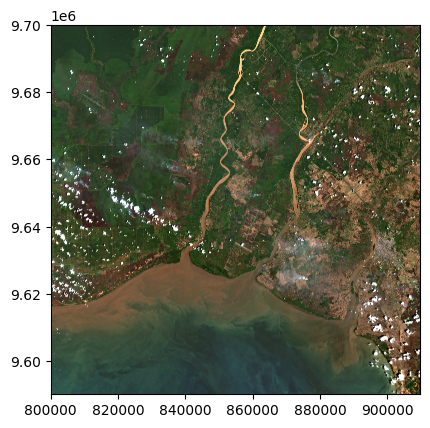

Datentypen vor der Konvertierung:
macroclass       int64
class_id         int64
MC_Name         object
ID_Name         object
geometry      geometry
dtype: object
Anzahl gültiger Geometrien nach Bereinigung: 999
Das bereinigte Shapefile wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/input_dir/SCP-training-data-T49MHS-19.shp gespeichert.


In [10]:
# Definiere die Input- und Output-Verzeichnisse
input_dir = '/content/drive/My Drive/Colab Notebooks/LCC/input_dir'
output_dir = '/content/drive/My Drive/Colab Notebooks/LCC/output_dir'

# Shapefile laden
shape_loc_19 = f'{input_dir}/SCP-training-data-T49MHS-19.shp'
gdf_19 = gpd.read_file(shape_loc_19)

# Rasterdaten laden
raster_loc_19 = f'{input_dir}/T49MHS_20191023T022741_TCI_10m.jp2'
raster_19 = rasterio.open(raster_loc_19)

# Anzeigen der ersten Zeilen der Shapefile-Daten
print(gdf_19.head())

# Anzeigen der Rasterdaten
show(raster_19)

# Prüfen und Konvertieren der 'macroclass'-Spalte
print("Datentypen vor der Konvertierung:")
print(gdf_19.dtypes)

# Prüfen, ob alle Werte in der Spalte macroclass vom Typ int64 sind
if gdf_19['macroclass'].dtype != np.int64:
    print("\nDie Spalte 'macroclass' enthält nicht nur int64-Werte!")

    # Identifizieren ungültiger Werte
    invalid_values = gdf_19[~gdf_19['macroclass'].apply(lambda x: isinstance(x, (int, np.integer)))]
    print("\nUngültige Werte in 'macroclass':")
    print(invalid_values)

    # Versuchen, die Werte zu konvertieren
    try:
        gdf_19['macroclass'] = gdf_19['macroclass'].astype('Int64')  # Pandas Integer-Typ mit NaN-Unterstützung
        print("\nKonvertierung erfolgreich. Neuer Datentyp:")
        print(gdf_19.dtypes)
    except ValueError as e:
        print("\nFehler bei der Konvertierung:", e)
        # Entfernen der Zeilen mit ungültigen Werten
        gdf_19 = gdf_19[gdf_19['macroclass'].apply(lambda x: isinstance(x, (int, np.integer)))]

# Überprüfen der Geometrie auf Fehler und Entfernen ungültiger Geometrien
def remove_invalid_geometry(df):
    invalid_geometries = df[~df.is_valid]
    if not invalid_geometries.empty:
        print("\nUngültige Geometrien:")
        print(invalid_geometries)
    valid_df = df[df.is_valid]
    print(f"Anzahl gültiger Geometrien nach Bereinigung: {len(valid_df)}")
    return valid_df

gdf_19 = remove_invalid_geometry(gdf_19)

# Geänderte Datei speichern und Originaldatei ersetzen
gdf_19.to_file(shape_loc_19)
print(f"Das bereinigte Shapefile wurde erfolgreich unter {shape_loc_19} gespeichert.")


### 2.1 Preprocessing
Laden der relevanten Bänder (B01, B02, B03, B04, B05, B06, B07, B08, B08A, B11, B12) und Resampling der 20 m Bänder auf 10 m mithilfe der bilinearen Resampling-Methode.

In [11]:
# Input-Dateien
raster_dir_19 = input_dir
shape_loc_19 = f'{input_dir}/SCP-training-data-T49MHS-19.shp'

# Relevante Bänder mit der höchsten Auflösung (10m und 20m) laden
band_files_10m_19 = [
    'T49MHS_20191023T022741_B02_10m.jp2', 'T49MHS_20191023T022741_B03_10m.jp2',
    'T49MHS_20191023T022741_B04_10m.jp2', 'T49MHS_20191023T022741_B08_10m.jp2'
]
band_files_20m_19 = [
    'T49MHS_20191023T022741_B01_20m.jp2', 'T49MHS_20191023T022741_B05_20m.jp2',
    'T49MHS_20191023T022741_B06_20m.jp2', 'T49MHS_20191023T022741_B07_20m.jp2',
    'T49MHS_20191023T022741_B8A_20m.jp2', 'T49MHS_20191023T022741_B11_20m.jp2',
    'T49MHS_20191023T022741_B12_20m.jp2'
]

bands_19 = []

# 10m Bänder laden
for band_file in band_files_10m_19:
    with rio.open(f'{raster_dir_19}/{band_file}') as src:
        bands_19.append(src.read(1))

# 20m Bänder laden und auf 10m resamplen
for band_file in band_files_20m_19:
    with rio.open(f'{raster_dir_19}/{band_file}') as src:
        data = src.read(
            out_shape=(src.count, src.height * 2, src.width * 2),
            resampling=Resampling.bilinear
        )
        bands_19.append(data[0])

bands_19 = np.array(bands_19)

# Shapefile laden
gdf_19 = gpd.read_file(shape_loc_19)

# Sicherstellen, dass das Shapefile das gleiche CRS hat wie das Raster
with rio.open(f'{raster_dir_19}/{band_files_10m_19[0]}') as src:
    crs_19 = src.crs
    transform_19 = src.transform

if gdf_19.crs != crs_19:
    gdf_19 = gdf_19.to_crs(crs_19)

# Dimensionen des Rasters bestimmen
height_19, width_19 = bands_19.shape[1], bands_19.shape[2]

Bestimmen und Visualisieren der spektralen Signaturen der Trainingsflächen (= MW Pixelwerte pro Klasse).

BOA Quantification Value: 10000.0
Band 0: BOA Add Offset: -1000.0
Band 1: BOA Add Offset: -1000.0
Band 2: BOA Add Offset: -1000.0
Band 3: BOA Add Offset: -1000.0
Band 4: BOA Add Offset: -1000.0
Band 5: BOA Add Offset: -1000.0
Band 6: BOA Add Offset: -1000.0
Band 7: BOA Add Offset: -1000.0
Band 8: BOA Add Offset: -1000.0
Band 9: BOA Add Offset: -1000.0
Band 10: BOA Add Offset: -1000.0
Band 11: BOA Add Offset: -1000.0
Band 12: BOA Add Offset: -1000.0


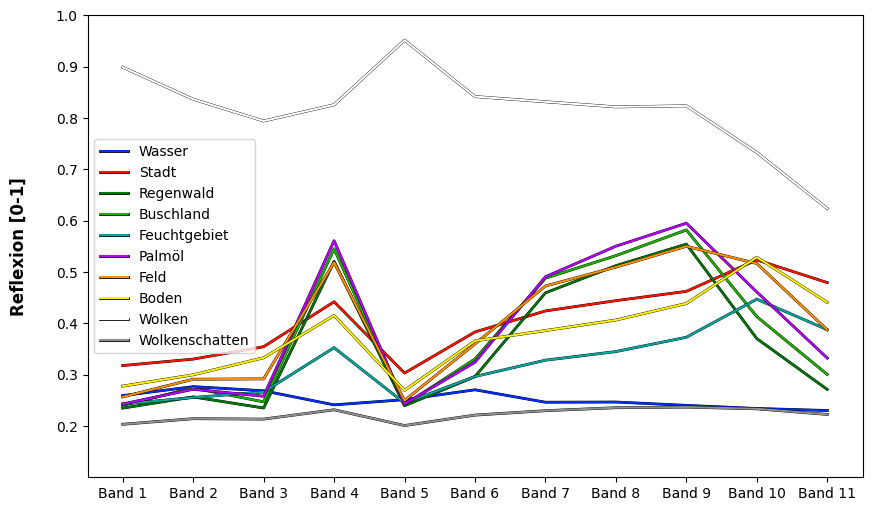

In [12]:
# Pfad zur Metadatendatei
metadata_19 = f'{input_dir}/MTD_MSIL2A_19.xml'

# Metadaten auslesen
tree = ET.parse(metadata_19)
root = tree.getroot()

# BOA Quantification Value extrahieren
boa_quantification_value = float(root.find(".//QUANTIFICATION_VALUES_LIST/BOA_QUANTIFICATION_VALUE").text)
print(f'BOA Quantification Value: {boa_quantification_value}')

# BOA Add Offset Werte extrahieren und ausgeben
boa_add_offsets = root.findall(".//BOA_ADD_OFFSET_VALUES_LIST/BOA_ADD_OFFSET")
reflectance_add_band = []
for offset in boa_add_offsets:
    band_id = int(offset.attrib['band_id'])
    add_offset = float(offset.text)
    reflectance_add_band.append(add_offset)
    print(f'Band {band_id}: BOA Add Offset: {add_offset}')

# Sicherstellen, dass die Anzahl der Bänder übereinstimmt
assert len(reflectance_add_band) >= bands_19.shape[0], "Anzahl der Bänder stimmt nicht überein"

# Nur die vorhandenen Bänder verwenden
reflectance_add_band = reflectance_add_band[:bands_19.shape[0]]

# Spektrale Signaturen der Trainingsflächen bestimmen
spectral_signatures_19 = {}
for macroclass in gdf_19['macroclass'].unique():
    class_pixels = []
    for _, row in gdf_19[gdf_19['macroclass'] == macroclass].iterrows():
        geom = row['geometry']
        mask = geometry_mask([geom], transform=transform_19, invert=True, out_shape=(bands_19.shape[1], bands_19.shape[2]))
        class_pixels.append([band[mask] for band in bands_19])

    class_pixels = np.concatenate(class_pixels, axis=1)
    spectral_signatures_19[macroclass] = np.mean(class_pixels, axis=1)

# Umwandlung der spektralen Signaturen von DN zu Reflectance
spectral_signatures_reflectance_19 = {}
for macroclass, dn_values in spectral_signatures_19.items():
    reflectance_values = (dn_values - np.array(reflectance_add_band)) / boa_quantification_value
    spectral_signatures_reflectance_19[macroclass] = reflectance_values

# Klassen und Farben
classes = {
    1: ('Wasser', '#002eff'),
    2: ('Stadt', '#ff1300'),
    3: ('Regenwald', '#007808'),
    4: ('Buschland', '#1eb100'),
    5: ('Feuchtgebiet', '#05a89d'),
    6: ('Palmöl', '#b800ff'),
    7: ('Feld', '#ff8f00'),
    8: ('Boden', '#fff200'),
    9: ('Wolken', '#ffffff'),
    10: ('Wolkenschatten', '#8f8f8f')
}


# Spektrale Signaturen visualisieren
plt.figure(figsize=(10, 6))
for macroclass, (class_name, color) in classes.items():
    if macroclass in spectral_signatures_reflectance_19:
        plt.plot(spectral_signatures_reflectance_19[macroclass], label=class_name, color=color, linewidth=1.5, linestyle='-',
                 path_effects=[pe.Stroke(linewidth=2, foreground='black'), pe.Normal()])

# Achsenbeschriftungen für jedes Band hinzufügen
bands_labels = [f'Band {i+1}' for i in range(len(reflectance_add_band))]
plt.xticks(ticks=range(len(reflectance_add_band)), labels=bands_labels)

plt.ylabel('Reflexion [0-1]', fontsize=12, fontweight='bold', labelpad=20)
plt.ylim(0.1, 1.0)
plt.yticks(np.arange(0.2, 1.1, 0.1))
plt.legend(fontsize=10)

# Diagramm als JPG in hoher Auflösung speichern
jpeg_path = os.path.join(output_dir, 'spektrale_signaturen19.jpg')
plt.savefig(jpeg_path, dpi=1200, format='jpg')

plt.show()

Features und Labels für das Modelltraining festelgen. Aufteilen der Traingsflächen in einen Trainings- (70 %) und Testdatensatz (30 %).

In [13]:
# Features und Labels extrahieren
features_19 = []
labels_19 = []

for _, row in gdf_19.iterrows():
    geom = row['geometry']
    macroclass = row['macroclass']

    # Maske für das Polygon erstellen
    mask = geometry_mask([geom], transform=transform_19, invert=True, out_shape=(src.height, src.width))

    # Pixelwerte innerhalb des Polygons extrahieren
    polygon_features = []
    for band in bands_19:
        masked_band = band[mask]
        polygon_features.append(masked_band)

    # Sicherstellen, dass alle Bänder die gleiche Anzahl von Pixeln haben
    min_length = min(len(band) for band in polygon_features)
    polygon_features = [band[:min_length] for band in polygon_features]

    # Features und Labels sammeln
    features_19.extend(np.array(polygon_features).T)
    labels_19.extend([macroclass] * min_length)

# In numpy Arrays umwandeln
features_19 = np.array(features_19)
labels_19 = np.array(labels_19)

# Trainings- und Testdaten aufteilen
X_train_19, X_test_19, y_train_19, y_test_19 = train_test_split(features_19, labels_19, test_size=0.3, random_state=42)

# Überprüfen der Aufteilung
print("Anzahl der Trainingsdaten:", len(X_train_19))
print("Anzahl der Testdaten:", len(X_test_19))

Anzahl der Trainingsdaten: 11926726
Anzahl der Testdaten: 5111454


Trainieren des Machine Learning Modells mit dem Random Forest Algorithmus (200 Entscheidungsbäume) mit den Trainingsdaten. Evaluieren des Modells mit den Testdaten und Ausgabe des Klassifikationsberichtes.

In [14]:
# Random Forest Modell direkt mit 200 Bäumen trainieren
print("Training des Random Forest Modells...")
rf_model_19 = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)

# Fortschrittsbalken simulieren (da RandomForest intern parallel trainiert)
with tqdm(total=1, desc="Training Progress") as pbar:
    rf_model_19.fit(X_train_19, y_train_19)  # Modell trainieren
    pbar.update(1)  # Fortschritt erhöhen

# Vorhersagen auf den Testdaten
y_pred_19 = rf_model_19.predict(X_test_19)

# Genauigkeit berechnen und ausgeben
accuracy_19 = accuracy_score(y_test_19, y_pred_19)
print(f"Genauigkeit: {accuracy_19:.2f}")

# Klassifikationsbericht als DataFrame speichern
classification_rep_19 = classification_report(y_test_19, y_pred_19, output_dict=True)
df_classification_report_19 = pd.DataFrame(classification_rep_19).transpose()

# Excel-Datei speichern
output_excel_path_19 = os.path.join(output_dir, 'classification_report_19.xlsx')
df_classification_report_19.to_excel(output_excel_path_19, index=True)

print(f"Klassifikationsbericht wurde erfolgreich unter {output_excel_path_19} gespeichert.")

Training des Random Forest Modells...


Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Genauigkeit: 1.00
Klassifikationsbericht wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/classification_report_19.xlsx gespeichert.


### 2.2 Band processing - Klassifikation
Klassifikation für das gesamte Raster.

In [15]:
# Klassifikation für das gesamte Raster durchführen
flat_bands_19 = bands_19.reshape(bands_19.shape[0], -1).T
print("Klassifikation des gesamten Rasters...")

# Fortschrittsbalken und Batch-Verarbeitung
predictions_19 = []
batch_size = 10000  # Batch-Größe
for i in tqdm(range(0, flat_bands_19.shape[0], batch_size), desc="Klassifikation Progress"):
    end = min(i + batch_size, flat_bands_19.shape[0])
    batch = flat_bands_19[i:end]
    predictions_19.extend(rf_model_19.predict(batch))


predictions_19 = np.array(predictions_19).reshape(bands_19.shape[1], bands_19.shape[2])

Klassifikation des gesamten Rasters...


Klassifikation Progress:   0%|          | 0/12057 [00:00<?, ?it/s]

"Confidence Map" für die Klassifizierung wird erstellt. Dazu berechnet das Modell für jeden Pixel im Raster die Wahrscheinlichkeiten, zu welcher der definierten Landnutzungsklassen (z.B. Wasser, Stadt, Regenwald, etc.) er gehört. Im Ergenis zeigt die Confidence Map die Sicherheit des Modells für die jeweilige Klassifizierung an.

In [16]:
# Daten als NumPy-Array
flat_bands_19_array = flat_bands_19.astype(np.float32)

# Confidence Map initialisieren
confidence_19 = np.zeros(flat_bands_19.shape[0], dtype=float)

print("Erstellung der Confidence Map mit CPU...")

# Berechnung der Confidence-Werte in Batches
for i in tqdm(range(0, flat_bands_19.shape[0], batch_size), desc="Confidence Map Progress"):
    end = min(i + batch_size, flat_bands_19.shape[0])
    batch = flat_bands_19_array[i:end]
    probs = rf_model_19.predict_proba(batch)
    confidence_19[i:end] = np.max(probs, axis=1)

# Ergebnisse in die ursprüngliche Rasterform bringen
confidence_19 = confidence_19.reshape(src.height, src.width)

Erstellung der Confidence Map mit CPU...


Confidence Map Progress:   0%|          | 0/12057 [00:00<?, ?it/s]

Ausgabe des Klassifikationsergebnisses und speichern als GeoTIFF.

In [17]:
# Pfade für die Ausgabe
output_classification_path_19 = f'{output_dir}/T49MHS-19-RandomForest-01.tif'
output_confidence_path_19 = f'{output_dir}/T49MHS-19-confidence-01.tif'

# Klassifikationsergebnis speichern
with rasterio.open(
    output_classification_path_19,
    'w',
    driver='GTiff',
    height=height_19,
    width=width_19,
    count=1,
    dtype='float32',
    crs=crs_19,
    transform=transform_19,
    compress='lzw'
) as dst:
    dst.write(predictions_19, 1)

# Confidence Map speichern
with rasterio.open(
    output_confidence_path_19,
    'w',
    driver='GTiff',
    height=height_19,
    width=width_19,
    count=1,
    dtype='float32',
    crs=crs_19,
    transform=transform_19,
    compress='lzw'
) as dst:
    dst.write(confidence_19, 1)

# Farben definieren
colors = ['#002eff', '#ff1300', '#007808', '#1eb100', '#05a89d', '#b800ff', '#ff8f00', '#fff200', '#ffffff', '#8f8f8f']
cmap = ListedColormap(colors)

# Klassifikationsergebnis anzeigen
plt.figure(figsize=(10, 10))
plt.title('Klassifikationsergebnis')
plt.imshow(predictions_19, cmap=cmap)
plt.colorbar(ticks=np.arange(1, 11), label='Klassen')
plt.show()

# Confidence Map anzeigen
plt.figure(figsize=(10, 10))
plt.title('Confidence Map')
plt.imshow(confidence_19, cmap='viridis')
plt.colorbar(label='Confidence')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Funktion sieve ermöglicht das Ersetzen isolierter Pixelwerte durch den Wert des größten Nachbarpatches. Entfernen kleiner Patches aus der Klassifizierung.

In [18]:
# Pfad zur Klassifikationsdatei
output_classification_path_19 = f'{output_dir}/T49MHS-19-RandomForest-01.tif'

# Klassifikationsergebnis laden, um CRS und Transform zu erhalten
with rasterio.open(output_classification_path_19) as src_19:
    predictions_19 = src_19.read(1)
    crs_19 = src_19.crs
    transform_19 = src_19.transform

# Verschiedene Werte für die Siebgröße ausprobieren
sizes = [200, 500, 1000]

for size in tqdm(sizes, desc="Sieve Sizes"):
    sieved_classification = sieve(predictions_19.astype(rasterio.int32), size=size)

    output_path = f'{output_dir}/T49MHS-19-RandomForest-01_sieved_size_{size}.tif'

    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=sieved_classification.shape[0],
        width=sieved_classification.shape[1],
        count=1,
        dtype='int32',
        crs=crs_19,
        transform=transform_19,
        compress='lzw'
    ) as dst:
        dst.write(sieved_classification, 1)

    print(f"Das Klassifikationsergebnis mit size={size} wurde erfolgreich unter {output_path} gespeichert.")

Sieve Sizes:   0%|          | 0/3 [00:00<?, ?it/s]

Das Klassifikationsergebnis mit size=200 wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/T49MHS-19-RandomForest-01_sieved_size_200.tif gespeichert.
Das Klassifikationsergebnis mit size=500 wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/T49MHS-19-RandomForest-01_sieved_size_500.tif gespeichert.
Das Klassifikationsergebnis mit size=1000 wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/T49MHS-19-RandomForest-01_sieved_size_1000.tif gespeichert.


### 2.3 Plots
Klassifikationsergebnis und Confidence Map mit Legende und Angabe der Koordinaten als JPEG im Ausgabeordner speichern.

In [19]:
# Pfade zu den Dateien
tif_path = f'{output_dir}/T49MHS-19-RandomForest-01_sieved_size_200.tif'
jpeg_path = f'{output_dir}/T49MHS-19-RandomForest-01_sieved_size_200.jpg'

# Klassen und Farben
classes = {
    1: ('Wasser', '#002eff'),
    2: ('Stadt', '#ff1300'),
    3: ('Regenwald', '#007808'),
    4: ('Buschland', '#1eb100'),
    5: ('Feuchtgebiet', '#05a89d'),
    6: ('Palmöl', '#b800ff'),
    7: ('Feld', '#ff8f00'),
    8: ('Boden', '#fff200'),
    9: ('Wolken', '#ffffff'),
    10: ('Wolkenschatten', '#8f8f8f')
}

# TIF-Datei laden
with rasterio.open(tif_path) as src:
    image = src.read(1)
    transform = src.transform
    crs = src.crs
    extent = rasterio.plot.plotting_extent(src)

# Bild anzeigen und Farbgebung anwenden
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.colors.ListedColormap([classes[i][1] for i in range(1, 11)])
bounds = np.arange(1, 12)
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
im = ax.imshow(image, cmap=cmap, norm=norm, extent=extent)

# Legende hinzufügen
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label,
                      markeredgewidth=1, markeredgecolor='black')
           for idx, (label, color) in classes.items()]
legend = ax.legend(handles=handles, title='Klassen (MC)', loc='upper left', bbox_to_anchor=(1, 1))
plt.setp(legend.get_title(), fontsize='12', fontweight='bold')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
plt.savefig(jpeg_path, dpi=1200, bbox_inches='tight')
plt.close()

In [20]:
# Pfade zu den Dateien
conf_path = f'{output_dir}/T49MHS-19-confidence-01.tif'
jpeg_path = f'{output_dir}/T49MHS-19-confidence-01.jpg'

# TIF-Datei laden
with rasterio.open(conf_path) as src:
    image = src.read(1)
    transform = src.transform
    crs = src.crs
    extent = rasterio.plot.plotting_extent(src)

# Bild anzeigen und Farbgebung anwenden
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.magma
im = ax.imshow(image, cmap=cmap, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
#cbar.ax.set_ylabel('Vertrauensbereich', fontsize=12, fontweight='bold', labelpad=40, rotation=270)
#cbar.ax.yaxis.set_label_position('right')

# Automatische Werte und benutzerdefinierte Beschriftungen hinzufügen
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.30, 1.0, '- hoch', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.30, 0.0, '- niedrig', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
plt.savefig(jpeg_path, dpi=1200, bbox_inches='tight')
plt.close()

## 3. Change detection
Änderungsdetektion zwischen der Klassifikation von 2019 und 2023 wird durchgeführt. Das Ergebnisse wird in einer Änderungsmatrix als EXCEL gespeichert.

In [21]:
# Pfade zu den Klassifikationsergebnissen
sieved_classification_path_19 = f'{output_dir}/T49MHS-19-RandomForest-01_sieved_size_200.tif'
sieved_classification_path_23 = f'{output_dir}/T49MHS-23-RandomForest-01_sieved_size_200.tif'

# Klassifikationsergebnisse laden
with rasterio.open(sieved_classification_path_19) as src_19:
    classification_19 = src_19.read(1)

with rasterio.open(sieved_classification_path_23) as src_23:
    classification_23 = src_23.read(1)

# Änderungsdetektion durchführen
change_detection = classification_23 - classification_19

# Fortschrittsbalken für die Erstellung der Änderungsmatrix
print("Erstellung der Änderungsmatrix...")

# Klassen definieren
classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
class_names_19 = [f'{name}_19' for name in ['Water', 'City', 'Rainforest', 'Bushland','Wetland', 'Monoculture', 'Agriculture', 'Soil', 'Cloud', 'Unclassified']]
class_names_23 = [f'{name}_23' for name in ['Water', 'City', 'Rainforest', 'Bushland','Wetland', 'Monoculture', 'Agriculture', 'Soil', 'Cloud', 'Unclassified']]

# Änderungsmatrix initialisieren
change_matrix = np.zeros((len(classes), len(classes)))

# Änderungsmatrix berechnen
for i, class_19 in enumerate(classes):
    for j, class_23 in enumerate(classes):
        change_matrix[i, j] = np.sum((classification_19 == class_19) & (classification_23 == class_23))

# In Prozent umrechnen
change_matrix_percent = (change_matrix / change_matrix.sum()) * 100

# Ergebniszeile hinzufügen
change_matrix_percent = np.vstack([change_matrix_percent, change_matrix_percent.sum(axis=0)])

# DataFrame erstellen
change_matrix_df = pd.DataFrame(change_matrix_percent, columns=class_names_23, index=class_names_19 + ['Total'])

# Änderungen als Excel-Datei speichern
change_matrix_path = os.path.join(output_dir, 'change_detection_matrix.xlsx')
change_matrix_df.to_excel(change_matrix_path, index=True)
print(f"Änderungsmatrix wurde erfolgreich unter {change_matrix_path} gespeichert.")

Erstellung der Änderungsmatrix...
Änderungsmatrix wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_matrix.xlsx gespeichert.


Die Änderungen werden visualisiert und als JPEG gespeichert. Änderungen von Macroclass 6 (Palmöl) werden separat dargestellt und als Matrix gespeichert.

In [32]:
# Änderungen visualisieren
colors = plt.cm.coolwarm(np.linspace(0, 1, 256)) # Benutzerdefinierte Farbkarte erstellen
colors[128] = [1, 1, 1, 1]  # Setze den mittleren Wert auf Weiß
custom_cmap = ListedColormap(colors)
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(change_detection, cmap=custom_cmap, vmin=-np.max(np.abs(change_detection)), vmax=np.max(np.abs(change_detection)), extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.5, 1.0, 'positiv', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.5, 0.5, 'keine', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.5, 0.0, 'negativ', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
change_detection_plot_path = os.path.join(output_dir, 'change_detection_plot.jpg')
plt.savefig(change_detection_plot_path, dpi=1200, bbox_inches='tight')
plt.close()

print(f"Änderungsplot wurde erfolgreich unter {change_detection_plot_path} gespeichert.")

#  Änderungen von macroclass 6 visualisieren
change_6 = np.zeros_like(change_detection)
change_6[(classification_19 != 6) & (classification_23 == 6) & (classification_19 != 9) & (classification_19 != 10) & (classification_23 != 9) & (classification_23 != 10)] = 1  # 6 dazugekommen
change_6[(classification_19 == 6) & (classification_23 != 6) & (classification_23 != 9) & (classification_23 != 10)] = -1  # 6 weniger geworden

# Flächenberechnung
pixel_area_km2 = (src_19.res[0] * src_19.res[1]) / 1e6  # Pixelgröße in km²

# Flächen in km² und Prozent berechnen
area_6_added_km2 = np.sum(change_6 == 1) * pixel_area_km2
area_6_removed_km2 = np.sum(change_6 == -1) * pixel_area_km2
total_area_km2 = classification_19.size * pixel_area_km2

area_6_added_percent = (area_6_added_km2 / total_area_km2) * 100
area_6_removed_percent = (area_6_removed_km2 / total_area_km2) * 100

# DataFrame erstellen
data = {
    'Fläche (km²)': [area_6_added_km2, area_6_removed_km2],
    'Prozent (%)': [area_6_added_percent, area_6_removed_percent]
}
df = pd.DataFrame(data, index=['Monoculture hinzugekommen', 'Monoculture verschwunden'])

# Änderungen als Excel-Datei speichern
change_6_excel_path = os.path.join(output_dir, 'change_detection_matrix_6.xlsx')
df.to_excel(change_6_excel_path, index=True)
print(f"Änderungen von Macroclass 6 wurden erfolgreich unter {change_6_excel_path} gespeichert.")

# Farben definieren
colors_6 = ['#007808', '#ffffff', '#b800ff']
cmap_6 = ListedColormap(colors_6)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(change_6, cmap=cmap_6, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('', fontsize=12, fontweight='bold', labelpad=40, rotation=270)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.50, 1.0, 'positiv', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.5, 'keine', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.0, 'negativ', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
change_6_plot_path = os.path.join(output_dir, 'change_detection_plot_6.jpg')
plt.savefig(change_6_plot_path, dpi=1200, bbox_inches='tight')
plt.close()

print(f"Änderungsplots wurden erfolgreich unter {change_detection_plot_path} und {change_6_plot_path} gespeichert.")

Änderungsplot wurde erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_plot.jpg gespeichert.
Änderungen von Macroclass 6 wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_matrix_6.xlsx gespeichert.
Änderungsplots wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_plot.jpg und /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_plot_6.jpg gespeichert.


Für eine genauere Differenzierung zwischen der Umwandlung der Klassen Regenwald, Buschland oder Feuchtgebiet in Palmöl oder umgekerht findet eine separate Berechnung und Visualisierung dieser Änderungen statt.

In [23]:
# Änderungen zwischen macroclass 6 und macroclass 3 visualisieren
change_6_3 = np.zeros_like(change_detection)
change_6_3[(classification_19 != 6) & (classification_23 == 6) & (classification_19 == 3)] = 1  # 6 dazugekommen von 3
change_6_3[(classification_19 == 6) & (classification_23 != 6) & (classification_23 == 3)] = -1  # 6 weniger geworden zu 3

# Flächenberechnung
pixel_area_km2 = (src_19.res[0] * src_19.res[1]) / 1e6  # Pixelgröße in km²

# Flächen in km² und Prozent berechnen
area_6_3_added_km2 = np.sum(change_6_3 == 1) * pixel_area_km2
area_6_3_removed_km2 = np.sum(change_6_3 == -1) * pixel_area_km2
total_area_km2 = classification_19.size * pixel_area_km2

area_6_3_added_percent = (area_6_3_added_km2 / total_area_km2) * 100
area_6_3_removed_percent = (area_6_3_removed_km2 / total_area_km2) * 100

# DataFrame erstellen
data = {
    'Fläche (km²)': [area_6_3_added_km2, area_6_3_removed_km2],
    'Prozent (%)': [area_6_3_added_percent, area_6_3_removed_percent]
}
df = pd.DataFrame(data, index=['Von 3 zu 6 hinzugekommen', 'Von 6 zu 3 verschwunden'])

# Änderungen als Excel-Datei speichern
change_6_3_excel_path = os.path.join(output_dir, 'change_detection_matrix_6_3.xlsx')
df.to_excel(change_6_3_excel_path, index=True)
print(f"Änderungen zwischen Macroclass 6 und 3 wurden erfolgreich unter {change_6_3_excel_path} gespeichert.")

# Farben definieren
colors_6_3 = ['#007808', '#ffffff', '#b800ff']
cmap_6_3 = ListedColormap(colors_6_3)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(change_6_3, cmap=cmap_6_3, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('', fontsize=12, fontweight='bold', labelpad=40, rotation=270)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.50, 1.0, 'positiv', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.5, 'keine', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.0, 'negativ', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
change_6_3_plot_path = os.path.join(output_dir, 'change_detection_plot_6_3.jpg')
plt.savefig(change_6_3_plot_path, dpi=1200, bbox_inches='tight')
plt.close()

print(f"Änderungsplots wurden erfolgreich unter {change_6_3_plot_path} gespeichert.")

Änderungen zwischen Macroclass 6 und 3 wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_matrix_6_3.xlsx gespeichert.
Änderungsplots wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_plot_6_3.jpg gespeichert.


In [24]:
# Änderungen zwischen macroclass 6 und macroclass 4 visualisieren
change_6_4 = np.zeros_like(change_detection)
change_6_4[(classification_19 != 6) & (classification_23 == 6) & (classification_19 == 4)] = 1  # 6 dazugekommen von 4
change_6_4[(classification_19 == 6) & (classification_23 != 6) & (classification_23 == 4)] = -1  # 6 weniger geworden zu 4

# Flächenberechnung
pixel_area_km2 = (src_19.res[0] * src_19.res[1]) / 1e6  # Pixelgröße in km²

# Flächen in km² und Prozent berechnen
area_6_4_added_km2 = np.sum(change_6_4 == 1) * pixel_area_km2
area_6_4_removed_km2 = np.sum(change_6_4 == -1) * pixel_area_km2
total_area_km2 = classification_19.size * pixel_area_km2

area_6_4_added_percent = (area_6_4_added_km2 / total_area_km2) * 100
area_6_4_removed_percent = (area_6_4_removed_km2 / total_area_km2) * 100

# DataFrame erstellen
data = {
    'Fläche (km²)': [area_6_4_added_km2, area_6_4_removed_km2],
    'Prozent (%)': [area_6_4_added_percent, area_6_4_removed_percent]
}
df = pd.DataFrame(data, index=['Von 4 zu 6 hinzugekommen', 'Von 6 zu 4 verschwunden'])

# Änderungen als Excel-Datei speichern
change_6_4_excel_path = os.path.join(output_dir, 'change_detection_matrix_6_4.xlsx')
df.to_excel(change_6_4_excel_path, index=True)
print(f"Änderungen zwischen Macroclass 6 und 4 wurden erfolgreich unter {change_6_4_excel_path} gespeichert.")

# Farben definieren
colors_6_4 = ['#1eb100', '#ffffff', '#b800ff']
cmap_6_4 = ListedColormap(colors_6_4)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(change_6_4, cmap=cmap_6_4, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('', fontsize=12, fontweight='bold', labelpad=40, rotation=270)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.50, 1.0, 'positiv', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.5, 'keine', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.0, 'negativ', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
change_6_4_plot_path = os.path.join(output_dir, 'change_detection_plot_6_4.jpg')
plt.savefig(change_6_4_plot_path, dpi=1200, bbox_inches='tight')
plt.close()

print(f"Änderungsplots wurden erfolgreich unter {change_6_4_plot_path} gespeichert.")

Änderungen zwischen Macroclass 6 und 4 wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_matrix_6_4.xlsx gespeichert.
Änderungsplots wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_plot_6_4.jpg gespeichert.


In [25]:
# Änderungen zwischen macroclass 6 und macroclass 5 visualisieren
change_6_5 = np.zeros_like(change_detection)
change_6_5[(classification_19 != 6) & (classification_23 == 6) & (classification_19 == 5)] = 1  # 6 dazugekommen von 5
change_6_5[(classification_19 == 6) & (classification_23 != 6) & (classification_23 == 5)] = -1  # 6 weniger geworden zu 5

# Flächenberechnung
pixel_area_km2 = (src_19.res[0] * src_19.res[1]) / 1e6  # Pixelgröße in km²

# Flächen in km² und Prozent berechnen
area_6_5_added_km2 = np.sum(change_6_5 == 1) * pixel_area_km2
area_6_5_removed_km2 = np.sum(change_6_5 == -1) * pixel_area_km2
total_area_km2 = classification_19.size * pixel_area_km2

area_6_5_added_percent = (area_6_5_added_km2 / total_area_km2) * 100
area_6_5_removed_percent = (area_6_5_removed_km2 / total_area_km2) * 100

# DataFrame erstellen
data = {
    'Fläche (km²)': [area_6_5_added_km2, area_6_5_removed_km2],
    'Prozent (%)': [area_6_5_added_percent, area_6_5_removed_percent]
}
df = pd.DataFrame(data, index=['Von 5 zu 6 hinzugekommen', 'Von 6 zu 5 verschwunden'])

# Änderungen als Excel-Datei speichern
change_6_5_excel_path = os.path.join(output_dir, 'change_detection_matrix_6_5.xlsx')
df.to_excel(change_6_5_excel_path, index=True)
print(f"Änderungen zwischen Macroclass 6 und 5 wurden erfolgreich unter {change_6_5_excel_path} gespeichert.")

# Farben definieren
colors_6_5 = ['#05a89d', '#ffffff', '#b800ff']
cmap_6_5 = ListedColormap(colors_6_5)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(change_6_5, cmap=cmap_6_5, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel('', fontsize=12, fontweight='bold', labelpad=40, rotation=270)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
cbar.ax.text(2.50, 1.0, 'positiv', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.5, 'keine', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')
cbar.ax.text(2.50, 0.0, 'negativ', transform=cbar.ax.transAxes, fontsize=12, fontweight='bold', va='center')

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
change_6_5_plot_path = os.path.join(output_dir, 'change_detection_plot_6_5.jpg')
plt.savefig(change_6_5_plot_path, dpi=1200, bbox_inches='tight')
plt.close()

print(f"Änderungsplots wurden erfolgreich unter {change_6_5_plot_path} gespeichert.")

Änderungen zwischen Macroclass 6 und 5 wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_matrix_6_5.xlsx gespeichert.
Änderungsplots wurden erfolgreich unter /content/drive/My Drive/Colab Notebooks/LCC/output_dir/change_detection_plot_6_5.jpg gespeichert.


In der folgenden Abbildung werden die Änderungen der KLasse Palmölplantage in Regenwald, Buschland und Feuchtgebiet in einer gemeinsamen Grafik dargestellt.

In [37]:
# Kombinierte Änderungsmatrix erstellen
combined_change = np.zeros_like(change_detection)

# Werte für die Änderungen setzen
combined_change[change_6_3 == 1] = 1  # Von 3 zu 6 hinzugekommen
combined_change[change_6_3 == -1] = -1  # Von 6 zu 3 verschwunden
combined_change[change_6_4 == 1] = 2  # Von 4 zu 6 hinzugekommen
combined_change[change_6_4 == -1] = -2  # Von 6 zu 4 verschwunden
combined_change[change_6_5 == 1] = 3  # Von 5 zu 6 hinzugekommen
combined_change[change_6_5 == -1] = -3  # Von 6 zu 5 verschwunden

# Farben für die Änderungen definieren
colors_combined = [
    '#05a89d',  # Von 6 zu 5 verschwunden (-3)
    '#1eb100',  # Von 6 zu 4 verschwunden (-2)
    '#007808',  # Von 6 zu 3 verschwunden (-1)
    '#ffffff',  # Keine Änderung (0)
    '#b800ff',  # Von 3 zu 6 hinzugekommen (1)
    '#b800ff',  # Von 4 zu 6 hinzugekommen (2)
    '#b800ff'   # Von 5 zu 6 hinzugekommen (3)
]
cmap_combined = ListedColormap(colors_combined)

# Farbskala an die spezifischen Werte anpassen
bounds = [-3, -2, -1, 0, 1, 2, 3, 4]  # Grenzen für die Kategorien
norm = plt.cm.colors.BoundaryNorm(bounds, cmap_combined.N)

# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(combined_change, cmap=cmap_combined, norm=norm, extent=extent)

# Farbskala hinzufügen
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[-3, -2, -1, 0, 1, 2, 3])

# Mittige Positionen für die Beschriftungen berechnen
tick_positions = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]  # Mittelpunkte der Farbbereiche

# Farbskalenbeschriftungen
tick_labels = [
    'Von Palmölplantage zu Feuchtgebiet',  # -3
    'Von Palmölplantage zu Buschland',  # -2
    'Von Palmölplantage zu Regenwald',  # -1
    'Keine Änderung',           # 0
    '', # 1
    'Palmölplantage hinzugekommen', # 2
    ''  # 3
]
cbar.set_ticks(tick_positions)  # Mittige Positionen setzen
cbar.set_ticklabels(tick_labels)  # Beschriftungen hinzufügen

# Beschriftungen rechts platzieren und Abstand anpassen
cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_tick_params(pad=10)

# Koordinaten anzeigen
ax.set_xlabel('Longitude', fontsize=12, fontweight='bold', labelpad=20)
ax.set_ylabel('Latitude', fontsize=12, fontweight='bold', labelpad=20)
ax.yaxis.set_tick_params(rotation=90)
ax.grid(False)

# Koordinatenformatierung
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Bild speichern
combined_plot_path = os.path.join(output_dir, 'combined_change_detection_plot.jpg')
plt.savefig(combined_plot_path, dpi=1200, bbox_inches='tight')
plt.close()